# Boosting Proje

Bu projede, daha önce SVM ile yaptığımız Bank Marketing projesini bu sefer Boosting ile yapacağız.

SVM ve Grid Search kullanarak %62'lik bir ROC-AUC elde etmiştik.

Bakalım Boosting ile bu ROC-AUC değerinin üzerine çıkabilecek miyiz?

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

https://xgboost.readthedocs.io/en/latest/

## 1. Data Description

Bank Marketing Data Seti, 2008-2010 yıllarında, Portuguese Banking Institution tarafından hazırlanmış bir data settir.

Veri seti, Müşterilerin telefon ile aranarak yapılmış araştırma sonucu oluşturulmuştur.

Araştırmanın amacı müşterilerin bir hizmet (bank term deposit) için kayıt olup olmayacaklarını anlamaktır. (y değişkeni)

Cevap 'yes' ya da 'no' olarak kayıt edilmiştir.

**`Attribute Information:`**

**Input variables:**

`bank client data:`
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

`related with the last contact of the current campaign:`

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

`other attributes:`

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

`social and economic context attributes`

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21. y - has the client subscribed a term deposit? (binary: 'yes','no')

## 2. Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 3. Import Dataset

In [2]:
df = pd.read_csv('data/bank-additional.csv', sep=';')

In [3]:
# duration sütununu çıkaralım
# dataset açıklamasında geçtiği üzere

df = df.drop('duration',axis=1)

## 4. Exploratory Data Analysis (EDA)

In [4]:
# verinin şekli

df.shape

(4119, 20)

In [5]:
# ilk satırlar

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [6]:
# sütun adları

col_names = df.columns

col_names

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [7]:
# target variable'ın dağılımı

df['y'].value_counts()

no     3668
yes     451
Name: y, dtype: int64

In [8]:
# sınıfların (yes-no) yüzde dağılımını görelim

df['y'].value_counts() / np.float(len(df))

no     0.890507
yes    0.109493
Name: y, dtype: float64

Gördüğümüz gibi, no-yes sınıfları arasında büyük bir fark var (%89 - %11).

Bu da verinin inbalanced olduğunu gösteriyor. Sonuçları yorumlarken dikkat etmemiz lazım.

In [9]:
# özet verileri görelim

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  campaign        4119 non-null   int64  
 11  pdays           4119 non-null   int64  
 12  previous        4119 non-null   int64  
 13  poutcome        4119 non-null   object 
 14  emp.var.rate    4119 non-null   float64
 15  cons.price.idx  4119 non-null   float64
 16  cons.conf.idx   4119 non-null   float64
 17  euribor3m       4119 non-null   f

Hiç eksik data yok ama yine de görelim.

In [10]:
# eksik data kontrolü

df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
# toplam kolon sayısı

len(df.columns)

20

In [12]:
# numeric kolonların adedi

df.select_dtypes(include=['int64', 'float64']).shape

(4119, 9)

In [13]:
# numeric kolonlar

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

numeric_cols

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [14]:
# kategorik kolonların (object) adedi

df.select_dtypes(include='object').shape

(4119, 11)

In [15]:
# kategorik kolonlar (object)

cat_cols = df.select_dtypes(include='object').columns

cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

Veri Özeti:

* Toplam 4119 adet veri 
* 19 değişken
    * 9 adet numerik değişken
    * 10 adet kategorik değişken
* hiç eksik veri yok

#### Numerik Değişkenler

Şimdi numerik değişkenlerin dağılımına bakalım:

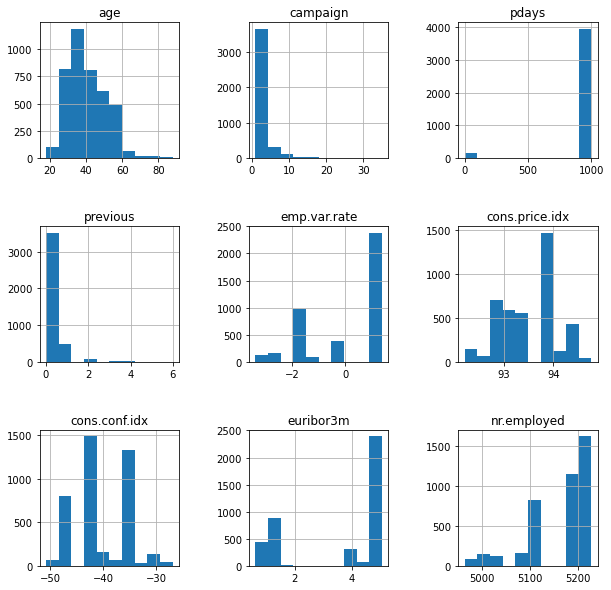

In [16]:
df.hist(column=numeric_cols,figsize=(10,10))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

Genelde değişkenlerin histogramlarına bakma sebebimiz, data içinde bir terslik var mı ya da outlier'lar var mı bunu anlamak.

Örneğin, yaşı 1000 olan birini görseydik, burada bir sorun var derdik.

#### Kategorik Değişkenler

ML'de kategorik değişkenler ikiye ayrılır:
1. Ordinal
2. Nominal

**Ordinal:** Ordinal değişkenlerde sıra önemlidir. ('çok memnunum', 'memnunun', 'az memnunum', 'memnun değilim' gibi.)

**Nominal:** Nominal değişkenlerde sıra önemli değildir. ('mavi', 'yeşil', 'kırmızı' gibi.)

**Ordinal Değişkenler:**

**poutcome**

In [17]:
df['poutcome'].value_counts()

nonexistent    3523
failure         454
success         142
Name: poutcome, dtype: int64

'poutcome' sütunu nominal gibi duruyor. success > nonexistent > failure

failure=-1, nonexistent=0, and success=1

In [18]:
df['poutcome'] = df['poutcome'].map({'failure': -1,'nonexistent': 0,'success': 1})

In [19]:
df['poutcome'].value_counts()

 0    3523
-1     454
 1     142
Name: poutcome, dtype: int64

**default**

In [20]:
df['default'].value_counts()

no         3315
unknown     803
yes           1
Name: default, dtype: int64

'default' sütunu da ordinal diyebiliriz. (kişinin hali hazırda kredisi var mı)

mevcutta kredisinin olmaması iyi.

no=1, unknown=0, yes=-1

In [21]:
df['default'] = df['default'].map({'yes': -1,'unknown': 0,'no': 1})

In [22]:
df['default'].value_counts()

 1    3315
 0     803
-1       1
Name: default, dtype: int64

**housing, loan**

'housing' -> mevcut ev kredisi var mı?

'loan' -> borcu var mı?

Bunlar da default gibi.

mevcutta kredisinin olmaması iyi.

no=1, unknown=0, yes=-1

In [23]:
df['housing'] = df['housing'].map({'yes': -1,'unknown': 0,'no': 1})
df['loan'] = df['loan'].map({'yes': -1,'unknown': 0,'no': 1})

**Nominal Değişkenler:**

"poutcome", "default", "housing" ve "loan" dışındakilere Nominal diyebiliriz.

Bunlarda sıranın bir önemi yok.

Bunlar için **one-hot-encoding** kullanacağız.

In [24]:
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [25]:
nominal = ['job','marital','education','contact','month','day_of_week']

In [26]:
# one-hot encoding yapmadan önce df'in şekli

df.shape

(4119, 20)

In [27]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [28]:
df = pd.get_dummies(df,columns=nominal)

In [29]:
# one-hot sonrası

df.shape

(4119, 55)

In [30]:
df.columns

Index(['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of

**y**

Son olarak target variable **y**'yi de encode edelim:

In [31]:
df['y']=df['y'].map({'yes': 1,'no': 0})
df.head()

,age,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,30,1,-1,1,2,999,0,0,-1.8,92.893,...,0,1,0,0,0,1,0,0,0,0
1,39,1,1,1,4,999,0,0,1.1,93.994,...,0,1,0,0,0,1,0,0,0,0
2,25,1,-1,1,1,999,0,0,1.4,94.465,...,0,0,0,0,0,0,0,0,0,1
3,38,1,0,0,3,999,0,0,1.4,94.465,...,0,0,0,0,0,1,0,0,0,0
4,47,1,-1,1,1,999,0,0,-0.1,93.200,...,0,0,1,0,0,0,1,0,0,0


## 5. Feature Vector & Target Variable

In [32]:
X = df.drop(['y'], axis=1)


y = df['y']

In [33]:
X.shape

(4119, 54)

In [34]:
y.shape

(4119,)

## 6. Train-Test Split

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [36]:
# X_train ve X_test şekilleri

X_train.shape, X_test.shape

((3295, 54), (824, 54))

## 7. Feature Scaling

In [37]:
# X_train sütunlarını tut

cols = X_train.columns

Numerik sütunlar için Feature Scaling yapmamız lazım.

In [38]:
# veriler

X_train[numeric_cols]

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
3199,30,2,999,0,1.1,93.994,-36.4,4.856,5191.0
3258,42,2,999,0,1.4,93.444,-36.1,4.968,5228.1
3153,48,1,999,0,-0.1,93.200,-42.0,4.191,5195.8
399,30,2,999,1,-0.1,93.200,-42.0,4.021,5195.8
1410,28,1,999,0,-1.8,92.893,-46.2,1.291,5099.1
...,...,...,...,...,...,...,...,...,...
1033,50,17,999,0,1.4,94.465,-41.8,4.961,5228.1
3264,45,3,999,0,1.4,93.918,-42.7,4.961,5228.1
1653,27,2,999,0,-2.9,92.201,-31.4,0.879,5076.2
2607,56,3,999,0,1.4,93.918,-42.7,4.962,5228.1


Görüldüğü gibi numerik sütunların şekilleri oldukça farklı.

Eğer Scale yapmazsak yanlış sonuçlara varabiliriz.

X_train üzerinde StandardScaler'ı eğiteceğiz.

Hem X_train hem de X_test'i aynı şekilde Scale edeceğiz.

In [39]:
# StandardScaler yarat

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# X_train üzerinde fit ve transform yap
X_train = scaler.fit_transform(X_train)

# X_test'i transform yap
X_test = scaler.transform(X_test)

In [40]:
# StandardScaler transform sonrası veri yapıları değişir

type(X_train)

numpy.ndarray

In [41]:
# geri pandas.DataFrame'e çevirmemiz lazım

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [42]:
# veriler (scale edilmiş halde)

X_train[cols]

,age,default,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,-0.977249,0.491928,-0.917247,0.464636,-0.195607,0.204284,-0.356918,0.200672,0.656694,0.724940,...,-0.109444,1.418409,-0.355121,-0.12413,-0.126628,-0.475204,-0.514189,-0.510412,1.951978,-0.487638
1,0.179962,0.491928,-0.917247,0.464636,-0.195607,0.204284,-0.356918,0.200672,0.848657,-0.225414,...,-0.109444,-0.705015,-0.355121,-0.12413,-0.126628,-0.475204,-0.514189,-0.510412,1.951978,-0.487638
2,0.758567,0.491928,-0.917247,0.464636,-0.587892,0.204284,-0.356918,0.200672,-0.111158,-0.647026,...,-0.109444,-0.705015,2.815944,-0.12413,-0.126628,-0.475204,1.944812,-0.510412,-0.512301,-0.487638
3,-0.977249,0.491928,1.118677,0.464636,-0.195607,0.204284,1.495123,-2.444187,-0.111158,-0.647026,...,-0.109444,-0.705015,2.815944,-0.12413,-0.126628,2.104361,-0.514189,-0.510412,-0.512301,-0.487638
4,-1.170117,0.491928,1.118677,0.464636,-0.587892,0.204284,-0.356918,0.200672,-1.198948,-1.177496,...,-0.109444,1.418409,-0.355121,-0.12413,-0.126628,-0.475204,-0.514189,-0.510412,1.951978,-0.487638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,0.951435,-2.025002,1.118677,0.464636,5.688668,0.204284,-0.356918,0.200672,0.848657,1.538789,...,-0.109444,-0.705015,-0.355121,-0.12413,-0.126628,-0.475204,1.944812,-0.510412,-0.512301,-0.487638
3291,0.469264,-2.025002,-0.917247,-2.252268,0.196678,0.204284,-0.356918,0.200672,0.848657,0.593618,...,-0.109444,-0.705015,-0.355121,-0.12413,-0.126628,-0.475204,-0.514189,-0.510412,1.951978,-0.487638
3292,-1.266551,0.491928,-0.917247,0.464636,-0.195607,0.204284,-0.356918,0.200672,-1.902812,-2.373214,...,-0.109444,-0.705015,-0.355121,-0.12413,-0.126628,-0.475204,-0.514189,-0.510412,-0.512301,2.050700
3293,1.530041,0.491928,-0.917247,-2.252268,0.196678,0.204284,-0.356918,0.200672,0.848657,0.593618,...,-0.109444,-0.705015,-0.355121,-0.12413,-0.126628,-0.475204,1.944812,-0.510412,-0.512301,-0.487638


## 8. AdaBoost

In [54]:
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score


# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=400, learning_rate=1, random_state=0)

# Train Adaboost Classifer
model_abc = abc.fit(X_train, y_train)


#Predict the response for test dataset
y_pred_abc = model_abc.predict(X_test)

# roc_auc
print('AdaBoost ile ROC-AUC score: {0:0.2f}'.format(roc_auc_score(y_test, y_pred_abc)))

AdaBoost ile ROC-AUC score: 0.62


## 9. XGBoost

Önce **xgboost** paketini kurmamız lazım:

https://anaconda.org/conda-forge/xgboost

In [65]:
# Import the XGBoost classifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


# Create xgboost classifer object
xgb = XGBClassifier(n_estimators=400, max_depth=6, learning_rate=1, random_state=0)

# Train XGBoost Classifer
model_xgb = xgb.fit(X_train, y_train)


#Predict the response for test dataset
y_pred_xgb = model_xgb.predict(X_test)

# roc_auc
print('XGBoost ile ROC-AUC score: {0:0.2f}'.format(roc_auc_score(y_test, y_pred_xgb)))

[16:36:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost ile ROC-AUC score: 0.64


## 10. Sonuç

Görüldüğü gibi, her hangi bir CV yapmadan, hem AdaBoost hem de XGBoost ile SVM kadar ve hatta daha iyi sonuçlar elde ettik.

En iyi sonucu XGBoost verdi ve paralel çalıştığı için çok hızlı çalıştı.

Eğer XGBoost ile GridSearch Cross Validation yaparak Hyerparameter Tuning yaparsanız, daha sonuçlar da elde edebilirsiniz.